In [99]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs                     #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker
import scipy.io
import pickle
import global_PATHs
import math
import scipy.integrate

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


In [100]:
N_POWER_STEPS = 51
N_TIME_STEPS = 51

In [101]:
class PowerSystem():

    def __init__(self, parameters, *args, **kwargs):
        self.n_states = parameters['n_states']
        self.n_generators = parameters['n_generators']
        self.n_buses = parameters['n_buses']
        self.H_generators = parameters['H_generators']
        self.H_total = sum(self.H_generators)
        self.D_generators = parameters['D_generators']
        self.omega_0 = parameters['omega_0']
        self.V_i_V_j_B = parameters['V_i_V_j_B']

        self.A, self.B, self.C, self.D, self.F, self.G, self.u_equilibrium = self.create_system_matrices()

    def create_system_matrices(self):
        A = np.array([[0.0, 1.0],
                      [0.0, (-self.omega_0 / (2 * self.H_generators) * self.D_generators)[0]]])

        B = np.array([[0.0, 0.0],
                      [0.0, (self.omega_0 / (2 * self.H_generators))[0]]])

        C = np.array([[1.0, 0.0]])

        D = np.array([[self.V_i_V_j_B[0]]])

        F = np.array([[0.0],
                      [(-self.omega_0 / (2 * self.H_generators))[0]]])

        G = np.array([[0.0],
                      [1.0]])

        u_equilibrium = np.hstack([0,
                                   0]).reshape((-1, 1))

        return A, B, C, D, F, G, u_equilibrium

    def ode_right_hand_side_solve(self, t, x, u):
        x_vector = np.reshape(x, (-1, 1))
        u_vector = np.reshape(u, (-1, 1))

        FCX = self.D @ np.sin(self.C @ x_vector)

        dx = self.A @ x_vector + self.F @ FCX + self.B @ u_vector
        return dx[:, 0]

    def solve_ode(self,
                  t_span,
                  t_eval,
                  states_initial,
                  u):
        ode_solution = scipy.integrate.solve_ivp(self.ode_right_hand_side_solve,
                                                 t_span=t_span,
                                                 y0=states_initial.flatten(),
                                                 args=[u],
                                                 t_eval=t_eval,
                                                 rtol=1e-13)

        return ode_solution.y

    def initialise_dataset(self, n_ops):
        time_zeros = np.zeros((n_ops, 1))
        power_zeros = np.zeros((n_ops, self.n_buses))
        states_initial = np.zeros((n_ops, self.n_states))

        states_results_zeros = np.zeros((n_ops, self.n_states))
        states_t_results_zeros = np.zeros((n_ops, self.n_states))

        states_prediction_zeros = np.zeros((n_ops, self.n_states))
        states_physics_zeros = np.zeros((n_ops, self.n_states))
        data_type_zeros = np.zeros((n_ops, self.n_states))

        data_initialised = {'time': time_zeros,
                            'power': power_zeros,
                            'states_initial': states_initial,
                            'states_results': states_results_zeros,
                            'states_t_results': states_t_results_zeros,
                            'states_prediction': states_prediction_zeros,
                            'states_physics': states_physics_zeros,
                            'data_type': data_type_zeros}

        return data_initialised

    def evaluate_op_trajectory(self, data_ops, t_evaluation_vector):
        n_ops = data_ops['time'].shape[0]
        n_time_steps = len(t_evaluation_vector)

        t_span = np.concatenate([np.zeros(data_ops['time'].shape),
                                 np.ones(data_ops['time'].shape) * max(t_evaluation_vector)], axis=1)
        t_eval = np.repeat(t_evaluation_vector.reshape((1, -1)), repeats=n_ops, axis=0)

        states_initial = data_ops['states_initial']

        u_disturbance = data_ops['power'] @ self.G.T
        #u = self.u_equilibrium.T + u_disturbance
        u = u_disturbance
        solver_results = map(self.solve_ode,
                             t_span,
                             t_eval,
                             states_initial,
                             u)
        
        list_solver_results = list(solver_results)
        
        states_results = np.concatenate([single_solver_result.T for single_solver_result in list_solver_results],
                                        axis=0)

        data_ops.update(time=t_eval.flatten().reshape((-1, 1)),
                        power=np.repeat(data_ops['power'], repeats=n_time_steps, axis=0),
                        states_initial=np.repeat(data_ops['states_initial'], repeats=n_time_steps, axis=0),
                        states_results=states_results,
                        data_type=np.repeat(data_ops['data_type'], repeats=n_time_steps, axis=0))

        return data_ops

    def calculate_states_t(self, data_ops):
        states_results = data_ops['states_results']

        u_disturbance = data_ops['power'] @ self.G.T
        u = u_disturbance
        #u = self.u_equilibrium.T + u_disturbance

        solver_results = map(self.ode_right_hand_side_solve,
                             data_ops['time'],
                             states_results,
                             u)

        list_solver_results = list(solver_results)

        states_t_results = np.concatenate([single_solver_result.reshape((1, -1)) for single_solver_result in
                                           list_solver_results],
                                          axis=0)

        data_ops.update(states_t_results=states_t_results)

        return data_ops

    def create_collocation_points(self, time_vector, initial_state, power):
        n_ops = len(time_vector)  # strictly speaking they're a belong to the same operating point
        data_ops = self.initialise_dataset(n_ops=n_ops)

        data_ops.update(time=time_vector.reshape((-1, 1)),
                        power=np.repeat(power, repeats=n_ops).reshape((-1, 1)),
                        states_initial=np.repeat(initial_state.reshape((1, -1)),
                                                 repeats=n_ops, axis=0))

        return data_ops

    def create_data_points(self, time_vector, initial_state, power):
        data_ops = self.initialise_dataset(n_ops=N_POWER_STEPS)

        data_ops.update(power=power.reshape((1, 1)),
                        states_initial=initial_state.reshape((1, -1)))

        data_ops = self.evaluate_op_trajectory(data_ops, time_vector)

        data_ops = self.calculate_states_t(data_ops=data_ops)

        return data_ops


def create_SMIB_system():
    n_buses = 1
    n_generators = 1
    n_non_generators = n_buses - n_generators
    n_states = 2 * n_generators + 1 * n_non_generators

    omega_0 = 2 * np.pi * 50

    H_generators = np.array([omega_0 / 2 / 0.4])
    D_generators = np.array([0.15])

    V_i_V_j_B = np.array([0.2])
    incidence_matrix = np.ones((1, 1))

    system_parameters = {'n_buses': n_buses,
                         'n_generators': n_generators,
                         'n_non_generators': n_non_generators,
                         'n_states': n_states,
                         'H_generators': H_generators,
                         'D_generators': D_generators,
                         'omega_0': omega_0,
                         'V_i_V_j_B': V_i_V_j_B,
                         'incidence_matrix': incidence_matrix}

    print('Successfully created a SMIB system (1 bus, 1 generator)!')

    return system_parameters

In [102]:
import datetime
a = datetime.datetime.now()
system_parameters = create_SMIB_system()
power_system = PowerSystem(system_parameters)

n_power_steps = N_POWER_STEPS
power_values = np.linspace(0.1, 0.2, n_power_steps)
delta_initial = 0
time_vector = np.linspace(0, 50, N_TIME_STEPS)
#print(np.hstack((power_values.flatten()[:,None],time_vector.flatten()[:,None])))
data_ops = power_system.initialise_dataset(n_ops=N_POWER_STEPS)

data_ops.update(power=power_values.reshape((-1, 1)),
                states_initial=np.repeat(np.array([[delta_initial, 0]]),
                                         repeats=N_POWER_STEPS, axis=0))

data_ops = power_system.evaluate_op_trajectory(data_ops, time_vector)

data_ops = power_system.calculate_states_t(data_ops=data_ops)

data = data_ops
b = datetime.datetime.now()
timevals_conv.append(b-a)
print(b-a)

Successfully created a SMIB system (1 bus, 1 generator)!
0:00:00.033662


In [103]:
def trainingdata(N_u,N_f):
    
    n_power_step = N_POWER_STEPS
    n_time_steps = N_TIME_STEPS
    
    # Domain bounds
    lb=np.array([0.1,  0.         ])
    ub=np.array([0.2,  20.        ])
    
    xx1 = np.hstack((data['power'][::N_TIME_STEPS][:n_power_step], np.zeros((n_power_step, 1))))
    uu1 = np.real(data['states_initial'])
    
    X_u_train = xx1
    
    power_f = np.linspace(0.1, 0.2, n_power_step)
    time_f = np.linspace(0, 20, n_time_steps)

    power_f = np.repeat(power_f, n_time_steps).T
    time_f = np.tile(time_f, n_power_step).T
    X_f_train = np.hstack((power_f.flatten()[:,None],time_f.flatten()[:,None]))
    
    u_train = uu1
    
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx,:]
    u_train = u_train
    X_f_train = X_f_train.astype(float)
    
    return X_f_train, X_u_train, u_train 

In [104]:
N_u = 3
N_f = 10000
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)
X_f_train.shape

(153, 2)

In [105]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_IC(self,x,y):
        x_input = x.clone()
        x_input.requires_grad = True
        
        result = self.forward(x_input)
        result_x = autograd.grad(result,x_input,torch.ones([x.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        omega = result_x[:,[1]]
        
        loss_u = self.loss_function(result, y[:,[0]])
        loss_omega = self.loss_function(omega, y[:,[1]])
        
        loss_total = loss_u+loss_omega
        return loss_total
    
    def loss_PDE(self, x_to_train_f):
        
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                     
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

        u_x_2 = u_x[:,[1]]
        
        u_xx = autograd.grad(u_x,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]

        u_xx_2 = u_xx[:,[1]]
                        
        f = 0.4*u_xx_2 + 0.15*u_x_2 + 0.2 * torch.sin(u) - g[:,0] 
        
        loss_f = self.loss_function(f,f_hat)
        
        # calculate real values
        
        system_parameters = create_SMIB_system()
        power_system = PowerSystem(system_parameters)

        n_power_steps = N_POWER_STEPS
        power_values = np.linspace(0.1, 0.2, n_power_steps)
        delta_initial = 0.0
        time_vector = np.linspace(0, 20, N_TIME_STEPS)
        
        data_ops = power_system.initialise_dataset(n_ops=n_power_steps)

        data_ops.update(power=power_values.reshape((-1, 1)),
                        states_initial=np.repeat(np.array([[delta_initial, 0.0]]),
                                                 repeats=n_power_steps, axis=0))

        data_ops = power_system.evaluate_op_trajectory(data_ops, time_vector)

        exact = torch.from_numpy(data_ops['states_results'][:,[0]]).float().to(device)
        loss_exact = self.loss_function(u,exact)
        
        #total_loss_PDE = loss_exact
        total_loss_PDE = loss_f+loss_exact
        
        return total_loss_PDE
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_IC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_f+loss_u
        
        return loss_val.to(torch.float)
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_u_train, u_train, X_f_train)
        loss_val=loss_val.float()
        print(loss_val)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = np.reshape(u_pred.cpu().detach().numpy(),(101,51),order='F') 
        
        return error_vec, u_pred

In [106]:
nu=0.2;
noise = 0.0      

N_u = 3
N_f = 100
layers = [2, 20, 20, 20, 1]

# Domain bounds
lb=np.array([0.1,  0.         ])
ub=np.array([0.2,  20.        ])

# Training data
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)

params = list(PINN.parameters())


optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.01, 
                              max_iter = 50000, 
                              max_eval = None, 
                              tolerance_grad = 1e-06, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')


start_time = time.time()

optimizer.zero_grad()     # zeroes the gradient buffers of all parameters

optimizer.step(PINN.closure)

#torch.save(PINN.state_dict(), 'PINN')

'''
'Adam Optimizer'

optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 1000

start_time = time.time()

for i in range(max_iter):

    loss = PINN.loss(X_u_train, u_train, X_f_train)
           
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    
    loss.backward() #backprop

    optimizer.step()
    
    #if i % (max_iter/10) == 0:

        #error_vec, _ = PINN.test()

        #print(loss,error_vec)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))



#error_vec, u_pred = PINN.test()

#print('Test Error: %.5f'  % (error_vec))



#solutionplot(u_pred,X_u_train,u_train)

'''

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(2.8277, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(2.8223, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(2.7983, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(2.5552, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(2.5400, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(2.4097, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(1.7275, grad_fn=<AddBa

C:\Users\bekar\Anaconda3\envs\ml\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([153, 1])) that is different to the input size (torch.Size([153, 153])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Successfully created a SMIB system (1 bus, 1 generator)!
tensor(1.6352, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(1.2907, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(1.2748, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(1.1379, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(0.8298, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(0.8282, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(0.8213, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(0.7667, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(0.7659, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bus, 1 generator)!
tensor(0.7594, grad_fn=<AddBackward0>)
Successfully created a SMIB system (1 bu

KeyboardInterrupt: 

In [66]:
NN = Sequentialmodel(layers)

layers1 = [2, 20, 20, 20, 1]
PINN = Sequentialmodel(layers1)

Text(0.5, 1.0, 'P = 0.2 [p.u.]')

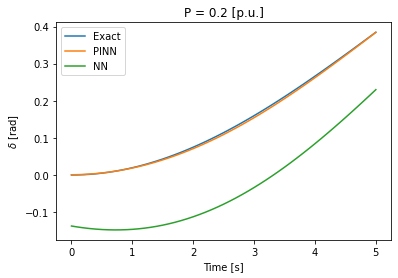

In [67]:
def gen_testdata():
    t, x, exact = data["time"][:N_TIME_STEPS], 0.1, data["states_results"][:,0][0:51]
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, t, x, y

X, t, x, y_true = gen_testdata()
NN.load_state_dict(torch.load('NN'))
NN.eval()

PINN.load_state_dict(torch.load('PINN'))
PINN.eval()

y_pred_nn = NN.forward(X)
y_pred = PINN.forward(X)
plt.plot(t, y_true)
plt.plot(t, y_pred.detach().numpy().flatten())
plt.plot(t, y_pred_nn.detach().numpy().flatten())
plt.legend(["Exact", "PINN", "NN"])
plt.xlabel("Time [s]")
plt.ylabel(r'$\delta$ [rad]')
plt.title('P = 0.2 [p.u.]')

In [80]:
timevals_conv = []
timevals_pin = []
timevals = [5, 10, 20, 50]

In [88]:
def gen_testdata():
    t, x, exact = data["time"][:101], 0.17, data_ops["states_results"][:,0][302:403]
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, t, x, y

X, t, x, y_true = gen_testdata()

import datetime
a = datetime.datetime.now()
y_pred = PINN.forward(X)
b = datetime.datetime.now()
print(b-a)
timevals_pin.append(b-a)

0:00:00.006575


In [ ]:
for i in range(len(timevals_pin)):
        time_container = timevals_pin[i].total_seconds()
        timevals_pin[i] = np.array(time_container)

for i in range(len(timevals_conv)):
        time_container = timevals_conv[i].total_seconds()
        timevals_conv[i] = np.array(time_container)        


([<matplotlib.axis.XTick at 0x250d89edcd0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

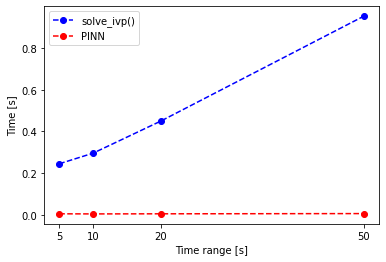

In [91]:

plt.plot(timevals, timevals_conv, '--bo')
plt.plot(timevals, timevals_pin, '--ro')
plt.legend(["solve_ivp()", "PINN"])
plt.xlabel("Time range [s]")
plt.ylabel('Time [s]')
plt.xticks(timevals)